In [ ]:
!pip install mne
!pip install PyWavelets

from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import mne
import pywt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
gamedata_folders = ["game1", "game3", "game4", "game5", "game7", "game8", "game9", "game11", "game12", "game13", "game15", "game16"]

#gamedata_folders = ["game3", "game7", "game11", "game15"]

# gamedata_folders = ["gamedata_files_game1", "gamedata_files_game2", "gamedata_files_game3", "gamedata_files_game4"]
#Each game contains 21 minutes of data

# Old game data folders: "gamedata_files_game1", "gamedata_files_game2", "gamedata_files_game3", "gamedata_files_game4", "gamedata_files_game5", "gamedata_files_game6", "gamedata_files_game7"

In [ ]:
val_gamedata_folders = ["game2", "game6", "game10", "game14"]

In [ ]:
#gamedata_eegvalues = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/Nov12-GameData-CSV-Files/gamedata_eegvalues_nov23.csv"
#gamedata_keystrokes = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/Nov12-GameData-CSV-Files/gamedata_keystrokes_nov23.csv"

list_of_actions = ["up", "down", "left", "right"]

list_of_columns = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2',
                   'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4', 'Timestamp'] # Replace last element with 'Time of Day'

In [ ]:
def convert_time_to_unix(time, timestamp):
  return time

In [ ]:
from datetime import datetime
import mne

sfreq = 329

columns = [
    "AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4"
]

def group_by_time_of_day(data_eegvalues_path, data_keystrokes_path):
  df_keystrokes = pd.read_csv(data_keystrokes_path)
  df_eegvalues = pd.read_csv(data_eegvalues_path, delimiter=',') # The eeg values from CSV, but not as df

  # eegvalues_df = pd.DataFrame(df_eegvalues) # Actual eegvalues dataframe
  # info = mne.create_info(ch_names = columns, sfreq=sfreq, ch_types="eeg")
  # raw = mne.io.RawArray(eegvalues_df[columns].values.T, info)



  #df_eegvalues['Time of Day'] = pd.to_datetime(df_eegvalues['Timestamp'], unit='s')
  #df_eegvalues['Time of Day'] = df_eegvalues['Time of Day'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')

  keystrokes_list = df_keystrokes.values.tolist()

  groups = {}
  print(f"keystrokes_list {keystrokes_list}")
  print(f"df_eegvalues {df_eegvalues}")
  print(f"keystrokes_list[0][0] {keystrokes_list[0][0]}")
  start_playing_time = convert_time_to_unix(keystrokes_list[0][1], df_eegvalues['TIMESTAMP'][0]) - keystrokes_list[0][0]

  for index, row in enumerate(keystrokes_list):
    if index == len(keystrokes_list) - 1:
      continue

    #TODO: convert end_time start_time to some time/datetime object
    start_time = keystrokes_list[index][0]
    end_time = keystrokes_list[index][1]

    group_time = df_eegvalues[(df_eegvalues['TIMESTAMP'] >= start_time) & (df_eegvalues['TIMESTAMP'] <= end_time)]
    print(len(group_time))
    if len(group_time) >= 800:
      group_time = group_time.iloc[0:800]
    else:
      continue
    if row[2] not in groups:
      groups[row[2]] = []
    groups[row[2]].append(group_time[columns].to_numpy())

    #groups['baseline']

  print("groups['baseline']", groups['baseline'][0].shape)
  baseline_array = np.array(groups['baseline'][0])


  baseline_mean = np.mean(baseline_array, axis=0)

  print("baseline_mean.shape = (14,)", baseline_mean.shape)

  for key in groups.keys():
    if key == 'baseline':
      continue
    for i in range(len(groups[key])):
      groups[key][i] = np.array(groups[key][i]) - baseline_mean

  return groups

In [ ]:
path_folder = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/CSV-FILES-WITH-BASELINE"

df_list = []

for folder_num in range(1, len(gamedata_folders)+1):
  gamedata_eegvalues = f"{path_folder}/game{folder_num}/eeg_data{folder_num}.csv"
  gamedata_keystrokes = f"{path_folder}/game{folder_num}/game_data{folder_num}.csv"
  #try:
  df_gamedata = group_by_time_of_day(gamedata_eegvalues, gamedata_keystrokes)
  df_list.append(df_gamedata)

# Collect 5 sets of data at 5 different times

In [ ]:
path_folder = "/content/drive/MyDrive/EMOTIV-CSV-Files-Updated/CSV-FILES-WITH-BASELINE"

val_df_list = []

for folder_num in range(1, len(val_gamedata_folders)+1):
  gamedata_eegvalues = f"{path_folder}/game{folder_num}/eeg_data{folder_num}.csv"
  gamedata_keystrokes = f"{path_folder}/game{folder_num}/game_data{folder_num}.csv"
  #try:
  val_df_gamedata = group_by_time_of_day(gamedata_eegvalues, gamedata_keystrokes)
  val_df_list.append(val_df_gamedata)

# Collect 5 sets of data at 5 different times

In [ ]:
df_list[0]['down'][0]

In [ ]:
group_data = {}

for key in df_list[0].keys():
  group_data[key] = []
  for group in df_list:
    for item in group[key]:
      group_data[key].append(item)

In [ ]:
val_group_data = {}

for key in val_df_list[0].keys():
  val_group_data[key] = []
  for group in val_df_list:
    for item in group[key]:
      val_group_data[key].append(item)

In [ ]:
train_dict = {}
for key in ['right', 'up', 'down', 'left']:
   for i in range(len(df_list)):
      for item in df_list[i][key]:
        if key not in train_dict:
          train_dict[key] = []
        train_dict[key].append(item )
        train_dict[key].append(item )
        # val_dict[key].append(item[list_of_columns].values[400:600])
        # val_dict[key].append(item[list_of_columns].values[600:])

In [ ]:
val_dict = {}
for key in ['right', 'up', 'down', 'left']:
   for i in range(len(val_df_list)):
      for item in val_df_list[i][key]:
        if key not in val_dict:
          val_dict[key] = []
        val_dict[key].append(item )
        val_dict[key].append(item )
        # val_dict[key].append(item[list_of_columns].values[400:600])
        # val_dict[key].append(item[list_of_columns].values[600:])

In [ ]:
'''
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def normalize_data(data_dict):
    scaler = MinMaxScaler()
    normalized_dict = {}

    for class_name, series_list in data_dict.items():
      series_list = np.array(series_list)
      num_samples, timesteps, num_features = series_list.shape
      series_list = series_list.reshape(-1, num_features)
      series_list = scaler.fit_transform(series_list)
      series_list = series_list.reshape(num_samples, timesteps, num_features)
      normalized_dict[class_name] = series_list

    return normalized_dict, scaler

def prepare_data(data_dict, label_encoder):
    class_labels = list(data_dict.keys())
    label_encoder.fit(class_labels)

    X, y = [], []
    for class_name, series_list in data_dict.items():
        for series in series_list:
            X.append(series)
            y.append(label_encoder.transform([class_name])[0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y, label_encoder

def build_gru_model(input_shape, num_classes):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_confusion_matrix(model, X_val, y_val, encoder):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    plt.figure(figsize=(6,6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

def downsample_by_mean(X_train, target_timesteps):
  n_samples, timesteps, num_channels = X_train.shape
  factor = timesteps // target_timesteps
  X_downsampled = X_train[:, :factor * target_timesteps, :].reshape(
      n_samples, target_timesteps, factor, num_channels
  ).mean(axis=2)
  return X_downsampled

label_encoder = LabelEncoder()

normalized_data_train, scaler = normalize_data(train_dict)
X_train, y_train, label_encoder = prepare_data(normalized_data_train, label_encoder)

normalized_data_val, scaler = normalize_data(val_dict)
X_val, y_val, label_encoder = prepare_data(normalized_data_val, label_encoder)

indices = np.arange(len(X_train))

np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

#new_timesteps = 256

#X_train = downsample_by_mean(X_train, new_timesteps)
#X_val = downsample_by_mean(X_val, new_timesteps)

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_encoder.classes_)

model = build_gru_model(input_shape, num_classes)
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

# Plot confusion matrix
plot_confusion_matrix(model, X_val, y_val, label_encoder)
'''

"\nimport numpy as np\nimport tensorflow as tf\nfrom sklearn.preprocessing import MinMaxScaler, LabelEncoder\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import GRU, Dense, Dropout\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\ndef normalize_data(data_dict):\n    scaler = MinMaxScaler()\n    normalized_dict = {}\n\n    for class_name, series_list in data_dict.items():\n      series_list = np.array(series_list)\n      num_samples, timesteps, num_features = series_list.shape\n      series_list = series_list.reshape(-1, num_features)\n      series_list = scaler.fit_transform(series_list)\n      series_list = series_list.reshape(num_samples, timesteps, num_features)\n      normalized_dict[class_name] = series_list\n\n    return normalized_dict, scaler\n\ndef prepare_data(data_dict, label_encoder):\n    class_labels = list(data_dict.keys())\n    label_encoder.fit(class_labels)\n\n    X, y = [], []\n    for class_name, series_list in

In [ ]:
import numpy as np
import scipy.signal
import torch
import torch.nn.functional as F

def eeg_to_spectrogram_tensor(
    eeg_raw,
    fs=128,
    nperseg=64,
    noverlap=32,
    resize_to=(64, 64),
    normalize=True,
    log_scale=True,
):
    """
    Chuyển tín hiệu EEG [T, 14] thành tensor ảnh [14, H, W] (dùng spectrogram)
    """
    n_channels = eeg_raw.shape[1]
    spectrograms = []

    for ch in range(n_channels):
        f, t, Sxx = scipy.signal.spectrogram(eeg_raw[:, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)

        if log_scale:
            Sxx = np.log1p(Sxx)

        if normalize:
            mean = np.mean(Sxx)
            std = np.std(Sxx)
            Sxx = (Sxx - mean) / (std + 1e-8)

        # Resize từng ảnh về cùng kích thước nếu cần
        Sxx_resized = F.interpolate(
            input=torch.tensor(Sxx).unsqueeze(0).unsqueeze(0),  # [1, 1, F, T]
            size=resize_to,
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()  # [H, W]

        spectrograms.append(Sxx_resized)

    # Stack lại thành tensor [14, H, W]
    spec_tensor = np.stack(spectrograms, axis=0)
    return spec_tensor

In [ ]:
from tqdm import tqdm
import numpy as np
import pywt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

def prepare_data(data_dict, label_encoder):
    class_labels = list(data_dict.keys())
    label_encoder.fit(class_labels)
    X, y = [], []
    for class_name, series_list in train_dict.items():
      for series in tqdm(series_list):
        series = eeg_to_spectrogram_tensor(series)
        X.append(series)  # shape: (32, width, 1)
        y.append(label_encoder.transform([class_name])[0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices], label_encoder

# CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Confusion matrix plotting
def plot_confusion_matrix(model, X_val, y_val, encoder):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    plt.figure(figsize=(6,6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

label_encoder = LabelEncoder()

# Skip normalization — already handled by scalogram
X_train, y_train, label_encoder = prepare_data(train_dict, label_encoder)
X_val, y_val, label_encoder = prepare_data(val_dict, label_encoder)

# Save the label_encoder to a file
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
    print("Label Encoder has been saved to a file")



100%|██████████| 1070/1070 [00:09<00:00, 114.92it/s]


Label Encoder has been saved to a file


In [ ]:
# Get shape like (63, width, 1)
input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)

# Build and train CNN
cnn_model = create_cnn_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.2477 - loss: 1.5537 - val_accuracy: 0.2582 - val_loss: 1.3853
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2601 - loss: 1.3886 - val_accuracy: 0.2586 - val_loss: 1.3922
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2644 - loss: 1.4003 - val_accuracy: 0.2514 - val_loss: 1.3863
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2602 - loss: 1.3864 - val_accuracy: 0.2750 - val_loss: 1.3834
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2733 - loss: 1.3848 - val_accuracy: 0.2722 - val_loss: 1.3802
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2621 - loss: 1.3819 - val_accuracy: 0.2641 - val_loss: 1.3840
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2697 - loss: 1.3875 - val_accuracy: 0.2799 - val_loss: 1.3753
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2683 - loss: 1.3822 - val_accuracy

<Figure size 600x600 with 0 Axes>

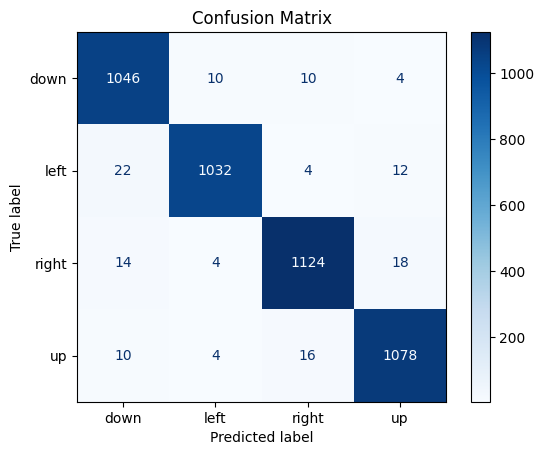

In [ ]:

history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Plot confusion matrix
plot_confusion_matrix(cnn_model, X_val, y_val, label_encoder)

In [ ]:
#cnn_model.save("eeg_prediction_model.h5")
# Save the trained model to a .keras file
cnn_model.save("may25_eeg_prediction_model.h5")
print("Model saved as may25_eeg_prediction_model.h5")